In [138]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt


In [139]:
def get_all_images(base_folder, resize_x, resize_y, read_size, zero_fill=4):
    """Read all images from the folders"""
    # Image data dictionary, keys will be image types and contents will be the images
    img_data = {}

    subfolders = [f.path for f in os.scandir(base_folder) if f.is_dir()]

    for folder in subfolders:
        images = []
        image_type = os.path.basename(folder)
        # Read read_size many images
        for i in range(read_size):
            #  Fill the image name with zeros to match the naming convention in the folders
            path_to_image = os.path.join(folder, str(i).zfill(zero_fill) + ".jpg")
            img = cv2.imread(path_to_image, cv2.IMREAD_COLOR)
            # Resize the image with given parameters
            img = cv2.resize(img, (resize_x, resize_y))
            images.append(img)
        img_data[image_type] = np.array(images)

    return img_data

def detect_edges(image, sigma=0.33, blur_kernel=(3, 3)):
    """Detects edges using Gaussian Blur and Canny edge detection"""
    # Convert the image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to reduce noise
    blurred_image = cv2.GaussianBlur(grayscale_image, blur_kernel, 0)

    # Compute the median of the image for adaptive thresholding
    median = np.median(grayscale_image)

    # Use median and the parameter sigma to calculate lower and upper threshold for Canny
    lower_threshold = int(max(0, (1.0 - sigma) * median))
    upper_threshold = int(min(255, (1.0 + sigma) * median))

    return cv2.Canny(blurred_image, lower_threshold, upper_threshold)

def get_all_detected_edges(img_dict, sigma=0.33, blur_kernel=(3, 3)):
    """Detect all edges from the image data dictionary"""
    edge_data = {}

    for img_type, images in img_dict.items():
        edge_images = []
        for image in images:
            edge_images.append(detect_edges(image, sigma, blur_kernel))
        edge_data[img_type] = np.array(edge_images)

    return edge_data

def hough_lines(edges, base_threshold=100, threshold_factor=0.1 ,theta_step=1, rho_step=1):
    """Detects lines from the edge pixels of an image using a custom implementation of the Hough Transform."""

    # Calculate the diagonal length for defining the rho array
    diagonal_length = int(np.sqrt(edges.shape[0] ** 2 + edges.shape[1] ** 2))

    # Define accumulator array
    thetas = np.deg2rad(np.arange(-90, 91, theta_step))
    rhos = np.arange(-diagonal_length, diagonal_length + rho_step, rho_step)
    accumulator = np.zeros([len(rhos), len(thetas)])

    # Select edge pixels from the image
    y_pixels, x_pixels = np.where(edges > 0)

    # Calculate the threshold using base_threshold and threshold_factor
    # threshold_factor is used to make the threshold higher if there are too many edge pixels in an image
    total_edges = np.sum(edges > 0)
    adaptive_threshold = base_threshold + (threshold_factor * total_edges)

    # Precompute cosine and sine of theta values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    range_theta = np.arange(len(thetas))

    # Edge pixels put a vote in the accumulator array
    for x, y in zip(x_pixels, y_pixels):
        rho_values = x * cos_t + y * sin_t
        rho_indexes = np.round((rho_values + diagonal_length) / rho_step).astype(int)
        accumulator[rho_indexes, range_theta] += 1

    # Select lines that have more votes than the adaptive_threshold
    selected_rho_indexes, selected_theta_indexes = np.where(accumulator > adaptive_threshold)
    selected_rho_values = rhos[selected_rho_indexes]
    selected_theta_values = thetas[selected_theta_indexes]

    selected_lines = np.column_stack((selected_rho_values, selected_theta_values))

    return selected_lines

def get_all_hough_lines(edge_dict, base_threshold=100, threshold_factor=0.1, theta_step=1, rho_step=1):
    """Detects all lines from the edge data dictionary using Hough Transform."""
    line_data = {}

    for img_type, edges in edge_dict.items():
        lines = []
        for edge in edges:
            lines.append(hough_lines(edge, base_threshold=base_threshold, threshold_factor=threshold_factor, theta_step=theta_step, rho_step=rho_step))
        line_data[img_type] = lines

    return line_data

def ransac_lines(edge_image, num_iterations=100, distance_threshold=2, min_inliers=50, min_inlier_ratio=0.05):
    """Detect lines from the edge pixels of an image using a custom implementation of the RANSAC algorithm."""
    # Select edge pixels from the image
    points = np.column_stack(np.where(edge_image > 0))
    # Define an array for selected RANSAC lines
    best_lines = []

    # If there are less than 2 edge pixels, return empty array
    if len(points) < 2:
        return np.array(best_lines)

    # Randomizer with a fixed random_state
    rng = np.random.default_rng(42)

    for _ in range(num_iterations):
        # Randomly select 2 distinct points
        idx = rng.choice(len(points), 2, replace=False)
        p1, p2 = points[idx]

        x1, y1 = p1
        x2, y2 = p2

        # Skip if points are identical
        if x1 == x2 and y1 == y2:
            continue

        # Compute line coefficients in the form of ax + by + c = 0
        a = y2 - y1
        b = x1 - x2
        c = x2 * y1 - x1 * y2

        # Normalize line coefficients
        norm = np.sqrt(a**2 + b**2)
        if norm == 0:
            continue
        # Compute distances of all points to the line
        distances = np.abs(a * points[:, 0] + b * points[:, 1] + c) / norm
        # Accept the points as inliers if their distance to the line is below the distance threshold
        inliers = points[distances < distance_threshold]

        # Calculate the inlier count and ratio
        inlier_count = len(inliers)
        inlier_ratio = inlier_count / len(points)

        # Accept line if it has enough inliers
        if inlier_count > min_inliers and inlier_ratio > min_inlier_ratio:
            x = inliers[:, 1]
            y = inliers[:, 0]

            # Calculate the line equation in the form of y = mx + n
            A = np.vstack([x, np.ones(len(x))]).T
            m, n = np.linalg.lstsq(A, y, rcond=None)[0]
            # Convert the line equation to polar coordinates
            theta = np.arctan(-1 / m) if m != 0 else np.pi / 2
            rho = n * np.sin(theta)

            best_lines.append((rho, theta))

    return np.array(best_lines)

def get_all_ransac_lines(edge_dict, num_iterations=100, distance_threshold=2, min_inliers=50, min_inlier_ratio=0.05):
    """Detect all lines from edge the edge data dictionary using RANSAC algorithm."""
    ransac_data = {}

    for img_type, edges in edge_dict.items():
        lines_per_image = []
        for edge in edges:
            lines = ransac_lines(edge, num_iterations, distance_threshold, min_inliers, min_inlier_ratio)
            lines_per_image.append(lines)
        ransac_data[img_type] = lines_per_image

    return ransac_data

def combine_lines(hough_lines_dict, ransac_lines_dict):
    """Combines hough lines data and ransac lines data"""

    combined_dict = {}

    for img_type in hough_lines_dict:
        combined_lines_per_image = []
        hough_lines_list = hough_lines_dict[img_type]
        ransac_lines_list = ransac_lines_dict.get(img_type, [])

        # Combine Hough and RANSAC lines for each image
        for hough_lines, ransac_lines in zip(hough_lines_list, ransac_lines_list):
            # Handle the cases that there are no hough lines and ransac lines are found
            if hough_lines.size == 0 and ransac_lines.size == 0:
                combined = np.empty((0, 2))
            elif hough_lines.size == 0:
                combined = ransac_lines
            elif ransac_lines.size == 0:
                combined = hough_lines
            else:
                combined = np.vstack((hough_lines, ransac_lines))

            combined_lines_per_image.append(combined)

        combined_dict[img_type] = combined_lines_per_image

    return combined_dict

def filter_similar_lines(lines, rho_thresh=20, theta_thresh=np.deg2rad(5)):
    """Removes similar lines based on rho and theta thresholds."""

    filtered = []

    for line in lines:
        rho1, theta1 = line
        is_similar = False
        # Compare with already kept lines
        for kept_rho, kept_theta in filtered:
            if abs(rho1 - kept_rho) < rho_thresh and abs(theta1 - kept_theta) < theta_thresh:
                is_similar = True
                break
        # Add line if it's not similar to any kept line
        if not is_similar:
            filtered.append((rho1, theta1))

    return np.array(filtered)

def filter_all_similar_lines(lines_dict, rho_thresh=20, theta_thresh=np.deg2rad(5)):
    """Removes similar lines from the lines dictionary based on rho and theta thresholds."""

    filtered_dict = {}

    for img_type, lines_list in lines_dict.items():
        filtered_lines_per_image = []
        for lines in lines_list:
            if lines.size == 0:
                filtered = np.empty((0, 2))
            else:
                filtered = filter_similar_lines(lines, rho_thresh, theta_thresh)
            filtered_lines_per_image.append(filtered)
        filtered_dict[img_type] = filtered_lines_per_image

    return filtered_dict


def find_intersections(lines, image_shape=(1024, 1024), margin=0):
    """Finds intersection points of lines that fall inside the image boundaries"""
    height, width = image_shape
    points = []

    # Iterate all different line pairs
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            rho1, theta1 = lines[i]
            rho2, theta2 = lines[j]

            # Represent lines in matrix form of a * [x, y]^T = b
            a = np.array([[np.cos(theta1), np.sin(theta1)], [np.cos(theta2), np.sin(theta2)]])
            b = np.array([[rho1], [rho2]])

            # Skip nearly parallel lines (determinant close to 0)
            if np.abs(np.linalg.det(a)) < 1e-10:
                continue

             # Solve for intersection point
            intersection = np.linalg.solve(a, b)
            x, y = intersection.flatten()

            # If the point lies within the image boundaries, add it to the points list
            if -margin <= x < width + margin and -margin <= y < height + margin:
                points.append((int(round(x)), int(round(y))))

    return np.array(points)

def find_all_intersections(lines_dict, image_shape, margin=0):
    """Finds intersection points that fall inside the image boundaries using lines dictionary"""

    intersections_dict = {}

    for img_type, lines_list in lines_dict.items():
        intersections_per_image = []
        for lines in lines_list:
            if lines.size == 0:
                intersections_per_image.append([])
            else:
                points = find_intersections(lines, image_shape, margin=margin)
                intersections_per_image.append(points)
        intersections_dict[img_type] = intersections_per_image

    return intersections_dict

def find_largest_quadrilateral(points):
    """Finds the largest quadrilateral from a set of points."""
    # If there is not enough point to form a quadrilateral, return empty list
    if len(points) < 4:
        return []

    pts = np.array(points, dtype=np.int32)

    # Compute the convex hull of the points
    hull = cv2.convexHull(pts)

    # Approximate the hull to a polygon
    epsilon = 0.02 * cv2.arcLength(hull, True)
    approx = cv2.approxPolyDP(hull, epsilon, True)

    # If it's already a quadrilateral, return the ordered points
    if len(approx) == 4:
        return order_points_clockwise(approx.reshape(4, 2))

     # Otherwise, try all 4-point combinations in the convex hull
    if len(hull) >= 4:
        max_area = 0
        best_quad = []

        for i in range(len(hull)):
            for j in range(i+1, len(hull)):
                for k in range(j+1, len(hull)):
                    for l in range(k+1, len(hull)):
                        quad = np.array([hull[i][0], hull[j][0], hull[k][0], hull[l][0]])
                        ordered = order_points_clockwise(quad)
                        area = polygon_area(ordered)

                        # Keep the quadrilateral with the largest area
                        if area > max_area:
                            max_area = area
                            best_quad = ordered

        return best_quad

    return []

def polygon_area(pts):
    """Calculates the area of a polygon using the shoelace formula."""

    # Extract x and y coordinates
    x = np.array([p[0] for p in pts])
    y = np.array([p[1] for p in pts])

    # Apply the shoelace formula
    return 0.5 * abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

def order_points_clockwise(pts):
    """Orders 4 points in clockwise order based on their angle from the center."""

    pts = np.array(pts)
    center = np.mean(pts, axis=0)
    angles = np.arctan2(pts[:,1] - center[1], pts[:,0] - center[0])
    ordered = pts[np.argsort(angles)]
    return ordered.tolist()

def find_all_largest_quadrilateral(points_dict):
    """Finds the largest quadrilateral from points dictionary."""

    quad_dict = {}

    for img_type, point_lists in points_dict.items():
        quadrilaterals_per_image = []
        for points in point_lists:
            quad = find_largest_quadrilateral(points)
            quadrilaterals_per_image.append(quad)
        quad_dict[img_type] = quadrilaterals_per_image

    return quad_dict

def apply_perspective_transform(image, points, output_size=(1024, 1024)):
    """Applies a perspective warp to the image using 4 corner points."""

    # If there are is not a correct number of points to apply perspective transformation, return raw image
    if len(points) != 4:
        return image

    # Source points (corners of the detected quadrilateral)
    src = np.array(points, dtype=np.float32)

    # Destination points (corners of the output rectangle)
    dst = np.array([
        [0, 0],
        [output_size[0] - 1, 0],
        [output_size[0] - 1, output_size[1] - 1],
        [0, output_size[1] - 1]
    ], dtype=np.float32)

    # Compute perspective transform matrix and apply warp
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, output_size)

    return warped

def warp_all_images(image_dict, quadrilateral_dict, output_size=(1024, 1024)):
    """Applies perspective warp to the all images in image dictionary using 4 corner points."""

    warped_images_dict = {}

    for img_type in image_dict:
        warped_list = []
        images = image_dict[img_type]
        quads = quadrilateral_dict[img_type]

        for img, quad in zip(images, quads):

            warped = apply_perspective_transform(img, quad, output_size)
            warped_list.append(warped)

        warped_images_dict[img_type] = np.array(warped_list)

    return warped_images_dict

def compute_ssim(image1, image2):
    """Compute the  Structural Similarity Index (SSIM) between two images."""

    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY) if len(image1.shape) == 3 else image1
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY) if len(image2.shape) == 3 else image2

    score = ssim(gray1, gray2)
    return score

def evaluate_all_ssim(warped_images_dict, ground_truth_dict):
    """Evaluate Structural Similarity Index (SSIM) scores for all images."""

    ssim_scores = {}

    for img_type in warped_images_dict:
        warped_imgs = warped_images_dict[img_type]
        ground_truth_images = ground_truth_dict.get(img_type, [])
        scores = []

        for warped, truth in zip(warped_imgs, ground_truth_images):
            score = compute_ssim(warped, truth)
            scores.append(score)

        ssim_scores[img_type] = scores

    return ssim_scores

def visualize_side_by_side(image1, image2, title1="Image 1", title2="Image 2"):
    """Visualize two images side by side."""

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    axes[0].set_title(title1)
    axes[0].axis("off")

    axes[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
    axes[1].set_title(title2)
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

def draw_lines(image, lines, color=(0, 255, 0), thickness=2):
    """Draws lines on the given image."""
    image_with_lines = image.copy()

    # Convert polar coordinates to cartesian coordinates
    for rho, theta in lines:

        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho

        # Compute two points on the line
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * a)
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * a)

        # Draw the line
        cv2.line(image_with_lines, (x1, y1), (x2, y2), color, thickness)

    return image_with_lines

def draw_points(image, points, color=(0, 0, 255), radius=5, thickness=-1):
    """Draws points on the given image."""

    image_with_points = image.copy()

    for x, y in points:
        cv2.circle(image_with_points, (int(x), int(y)), radius, color, thickness)

    return image_with_points



In [140]:
distorted_image_data = get_all_images("data/WarpDoc/distorted", 1024, 1024, 50)
digital_image_data = get_all_images("data/WarpDoc/digital", 1024, 1024, 50)

In [141]:
distorted_edge_data = get_all_detected_edges(distorted_image_data, sigma=0.8, blur_kernel=(7,7))

In [142]:
# One good and one bad example for visualization
curved_image = distorted_image_data["curved"][2]
random_image = distorted_image_data["random"][11]

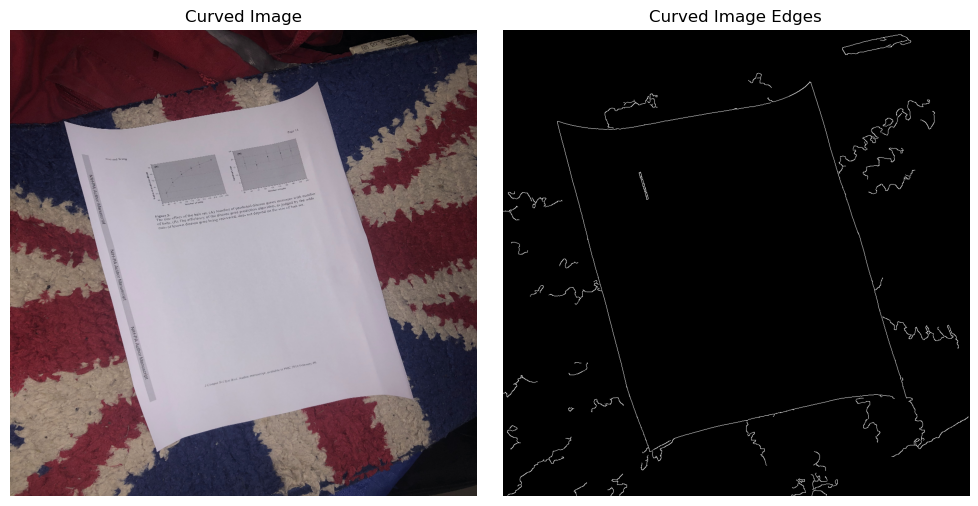

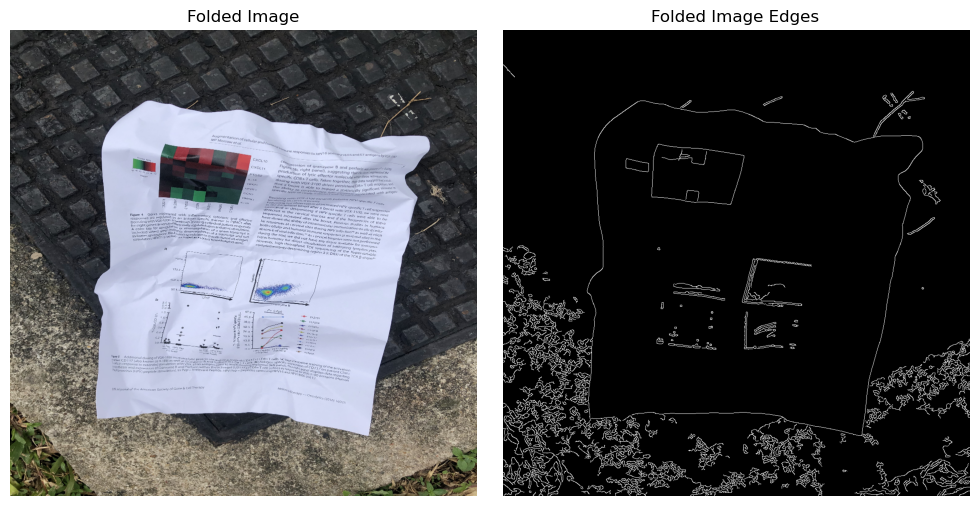

In [143]:
# Visualize edge points

curved_image_edges = distorted_edge_data["curved"][2]
random_image_edges = distorted_edge_data["random"][11]
visualize_side_by_side(curved_image, curved_image_edges, "Curved Image", "Curved Image Edges")
visualize_side_by_side(random_image, random_image_edges, "Folded Image", "Folded Image Edges")


In [144]:
hough_transform_lines = get_all_hough_lines(distorted_edge_data, base_threshold=100, threshold_factor=0.0015, theta_step=1, rho_step=1)

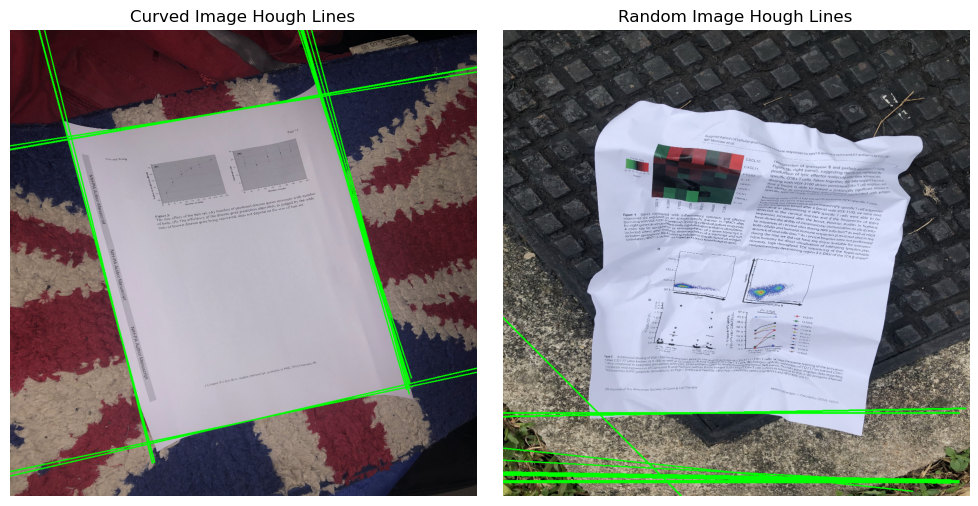

In [145]:
# Visualize Hough Lines
curved_hough_lines = hough_transform_lines["curved"][2]
random_hough_lines = hough_transform_lines["random"][11]
curved_image_hough_lines = draw_lines(curved_image, curved_hough_lines, color=(0, 255, 0))
random_image_hough_lines = draw_lines(random_image, random_hough_lines, color=(0, 255, 0))
visualize_side_by_side(curved_image_hough_lines, random_image_hough_lines, "Curved Image Hough Lines", "Random Image Hough Lines")


In [146]:
ransac_lines_data = get_all_ransac_lines(distorted_edge_data, 1000, 2, 300, 0.025)

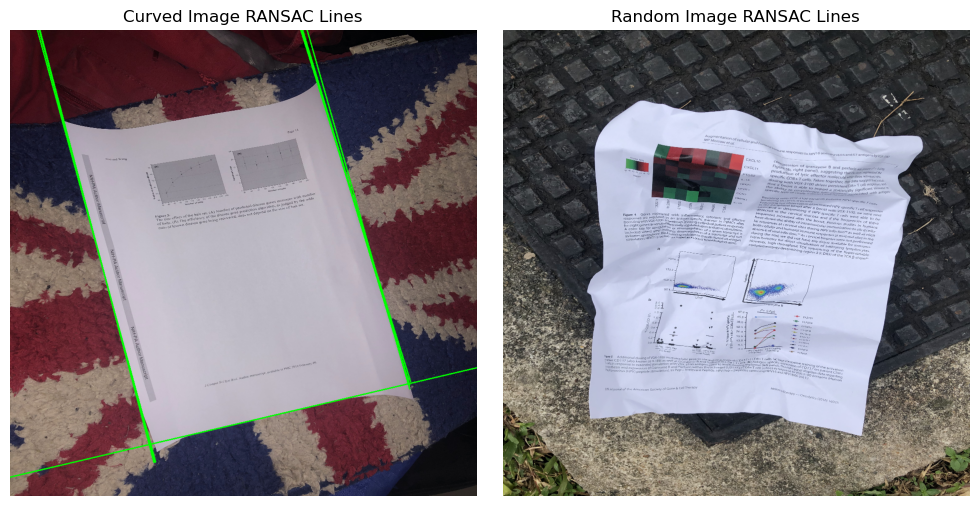

In [147]:
# Visualize RANSAC lines

curved_ransac_lines = ransac_lines_data["curved"][2]
random_ransac_lines = ransac_lines_data["random"][11]

curved_image_ransac_lines = draw_lines(curved_image, curved_ransac_lines, color=(0, 255, 0))
random_image_ransac_lines = draw_lines(random_image, random_ransac_lines, color=(0, 255, 0))

visualize_side_by_side(curved_image_ransac_lines, random_image_ransac_lines, "Curved Image RANSAC Lines", "Random Image RANSAC Lines")


In [148]:
combined_lines = combine_lines(hough_transform_lines, ransac_lines_data)

In [149]:
filtered_lines = filter_all_similar_lines(combined_lines, rho_thresh=20, theta_thresh=np.deg2rad(5))

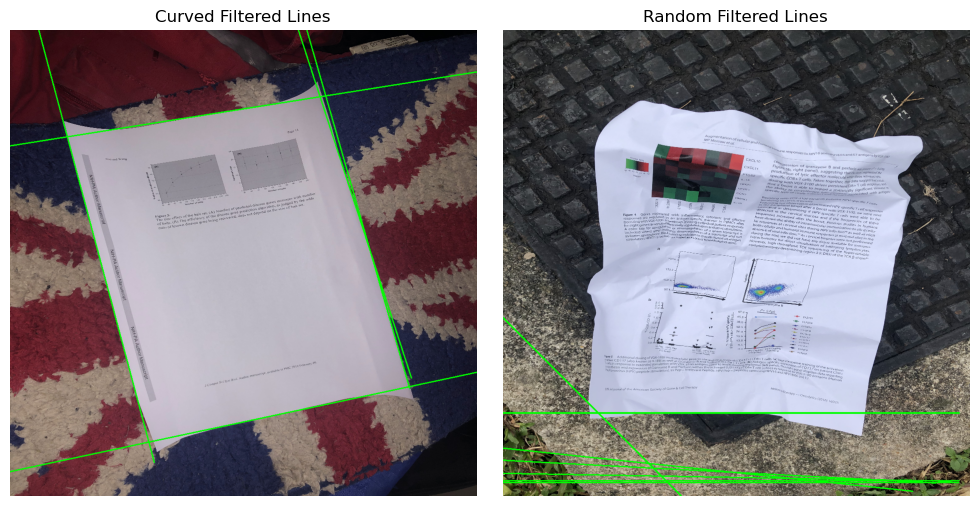

In [150]:
# Visualize filtered lines

curved_filtered_lines = filtered_lines["curved"][2]
random_filtered_lines = filtered_lines["random"][11]

curved_image_filtered_lines = draw_lines(curved_image, curved_filtered_lines, color=(0, 255, 0))  # Cyan
random_image_filtered_lines = draw_lines(random_image, random_filtered_lines, color=(0, 255, 0))  # Cyan

visualize_side_by_side(curved_image_filtered_lines, random_image_filtered_lines, "Curved Filtered Lines", "Random Filtered Lines")



In [151]:
intersection_points = find_all_intersections(filtered_lines, image_shape=(1024, 1024))

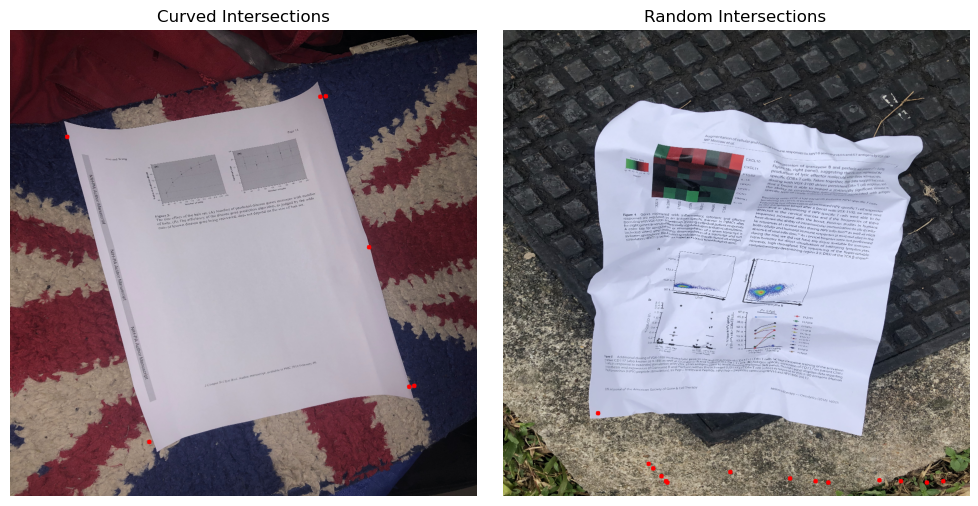

In [152]:
# Visualize line intersection points

curved_intersections = intersection_points["curved"][2]
random_intersections = intersection_points["random"][11]

curved_image_intersections = draw_points(curved_image, curved_intersections, color=(0, 0, 255))
random_image_intersections = draw_points(random_image, random_intersections, color=(0, 0, 255))

visualize_side_by_side(curved_image_intersections, random_image_intersections, "Curved Intersections", "Random Intersections")


In [153]:
corner_points = find_all_largest_quadrilateral(intersection_points)

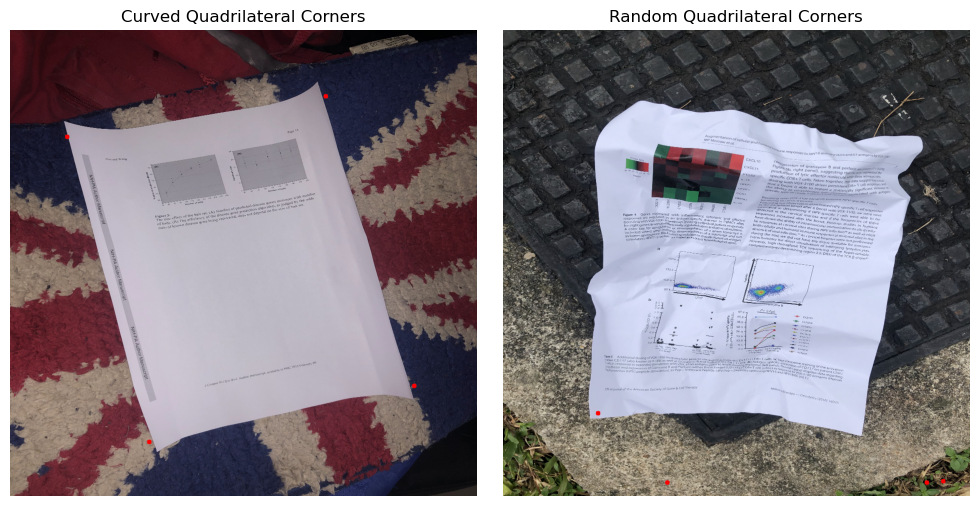

In [154]:
# Visualize corner points

curved_corners = corner_points["curved"][2]
random_corners = corner_points["random"][11]

curved_image_corners = draw_points(curved_image, curved_corners, color=(0, 0, 255))
random_image_corners = draw_points(random_image, random_corners, color=(0, 0, 255))

visualize_side_by_side(curved_image_corners, random_image_corners, "Curved Quadrilateral Corners", "Random Quadrilateral Corners")


In [155]:
warped_images = warp_all_images(distorted_image_data, corner_points)

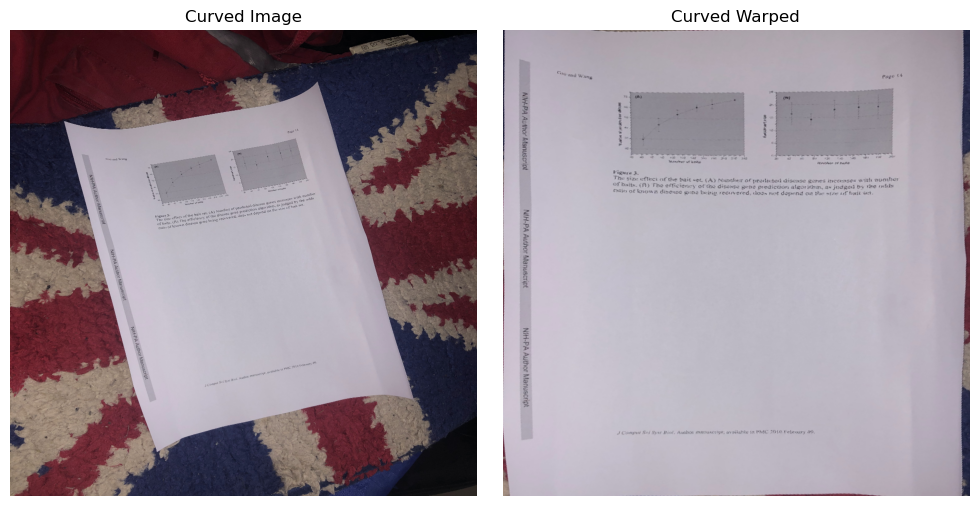

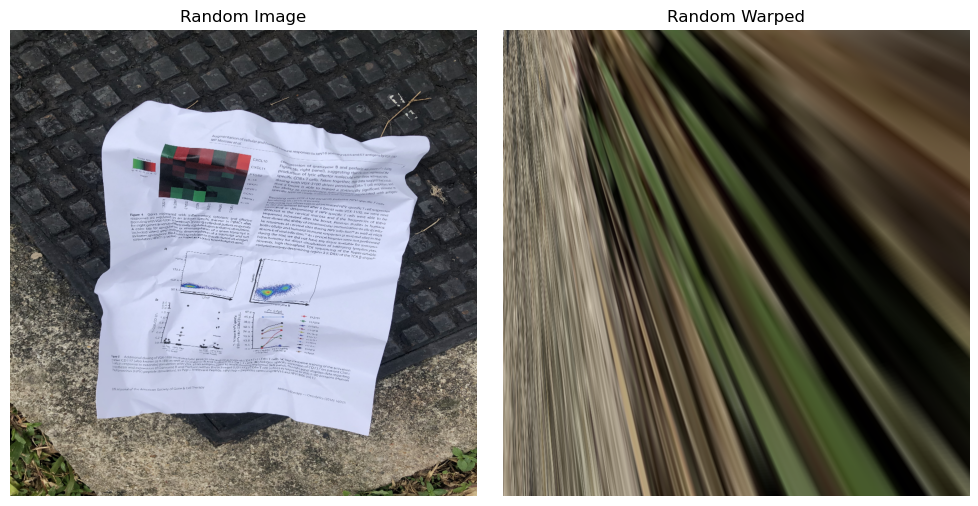

In [156]:
# Visualize warped images

curved_warped = warped_images["curved"][2]
random_warped = warped_images["random"][11]

visualize_side_by_side(curved_image, curved_warped, "Curved Image", "Curved Warped")
visualize_side_by_side(random_image, random_warped, "Random Image", "Random Warped")


In [157]:
curved_image_digital = digital_image_data["curved"][2]
random_image_digital = digital_image_data["random"][11]


In [158]:
ssim_results = evaluate_all_ssim(warped_images, digital_image_data)

In [159]:
print(f"Curved Image SSIM: {ssim_results['curved'][2]:.2f}")
print(f"Random Image SSIM: {ssim_results['random'][11]:.2f}")

Curved Image SSIM: 0.82
Random Image SSIM: 0.18


In [160]:
for img_type, scores in ssim_results.items():
    print(f"{img_type.capitalize()}")
    print(f"--------------------------")
    avg_score = sum(scores) / len(scores)
    print(f"Average SSIM = {avg_score:.4f}")
    print("\n")

Curved
--------------------------
Average SSIM = 0.3579


Fold
--------------------------
Average SSIM = 0.3673


Incomplete
--------------------------
Average SSIM = 0.3703


Perspective
--------------------------
Average SSIM = 0.3485


Random
--------------------------
Average SSIM = 0.3497


Rotate
--------------------------
Average SSIM = 0.3680


